# Padim Example

#### Import dependencies

In [1]:
import os
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

In this notebook the MVTec dataset will be used. It can be downloaded from: https://www.mvtec.com/company/research/datasets/mvtec-ad.

Change `DATASET_PATH` to the path where you save the dataset.

Also, if you want to save and load the model. Add a folder where to save them and change the path of `MODEL_DATA_PATH` to that folder.

In [2]:
DATASET_PATH = os.path.realpath("../data_warehouse/new")
MODEL_DATA_PATH = os.path.realpath("./distributions/")

#### Load dataset

In [3]:
object_name = "purple_duck"
camera_name = "cam_0_left"
dataset = anodet.AnodetDataset(os.path.join(DATASET_PATH, f"{object_name}/train/good/{camera_name}"))
dataloader = DataLoader(dataset, batch_size=32)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 150


#### Init the model

In [4]:
padim = anodet.Padim(backbone='resnet18')

In [5]:
print(padim)

Padim(backbone=resnet18, device=cpu, mean=None, cov_inv=None, channel_indices=tensor([408,   9, 247, 435, 199, 165, 424, 405, 266,  51, 227, 262, 187, 413,
        369, 434, 366, 188, 198, 406,  49, 364, 381,  71, 447, 443,  52, 209,
         79, 223, 242, 228, 376, 268, 177, 315, 311,  45,  18,  42, 325, 394,
        423, 421, 185, 352, 171,   1, 189, 154,  93,  69,  81, 422, 146,  82,
         46, 117, 298,  61, 235, 349, 287,  12, 357, 210,  11,  10, 126, 419,
        170, 176, 236, 312,  89, 281, 354, 218,  31,  34, 196,  50, 305, 428,
         95, 109, 361,  17, 363, 316, 336, 169, 398, 382, 237, 264, 440, 318,
        403,  48]), layer_indices=[0, 1, 2], layer_hook=None)


In [6]:
print(padim.channel_indices.shape)

torch.Size([100])


With resnet18 we get 100 random indices out of a total of 448. Why?

It could be (?) to introduce randomness or perturbations into the process, thereby enhancing the robustness of the model and ensuring better generalization.

#### Fit the model to the dataset

In [7]:
padim.fit(dataloader)

Feature extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature extraction: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


In [8]:
padim

Padim(backbone=resnet18, device=cpu, mean=tensor([[2.8942e-01, 1.7433e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.1433e+00],
        [2.8942e-01, 4.4421e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.0942e+00],
        [2.8942e-01, 1.1617e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.2511e+00],
        ...,
        [1.3644e-01, 1.2187e-02, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         0.0000e+00],
        [1.3644e-01, 0.0000e+00, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         2.7906e-04],
        [1.3644e-01, 0.0000e+00, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         0.0000e+00]]), cov_inv=tensor([[[ 9.8882e+01,  1.5433e-01,  5.0537e-01,  ..., -4.6098e-01,
           0.0000e+00, -8.6831e-02],
         [ 1.5433e-01,  9.8667e+01,  2.9961e-01,  ..., -2.4155e-01,
           0.0000e+00, -1.4212e-01],
         [ 5.0537e-01,  2.9961e-01,  9.6196e+01,  ...,  8.3368e-01,
           0.0000e+00, -1.2028e-02],
         ...,
         [-4.6098e-01, -

#### Save the necessary parameters

In [9]:
distributions_path = './distributions/'
torch.save(padim.mean, os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_mean.pt"))
torch.save(padim.cov_inv, os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_cov_inv.pt"))

# 

## Inference
#### Load test images

In [10]:
anomaly = ["albinism"]

paths = [
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/000.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/001.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/002.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/good/{camera_name}/000.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/good/{camera_name}/001.png"),
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the model data

In [11]:
mean = torch.load(os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_mean.pt")) 
cov_inv = torch.load(os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_cov_inv.pt"))

#### init the model

In [12]:
padim = anodet.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

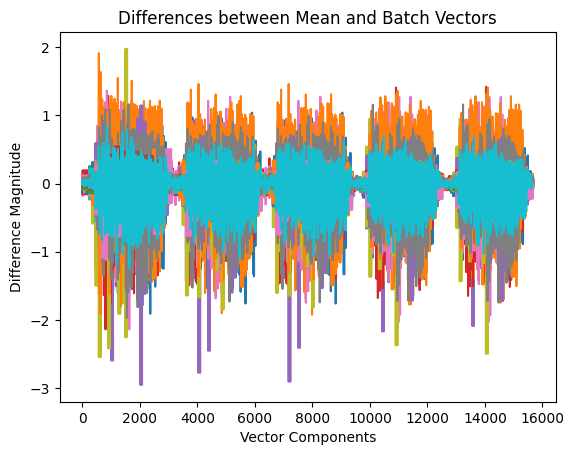

In [13]:
image_scores, score_maps = padim.predict(batch)

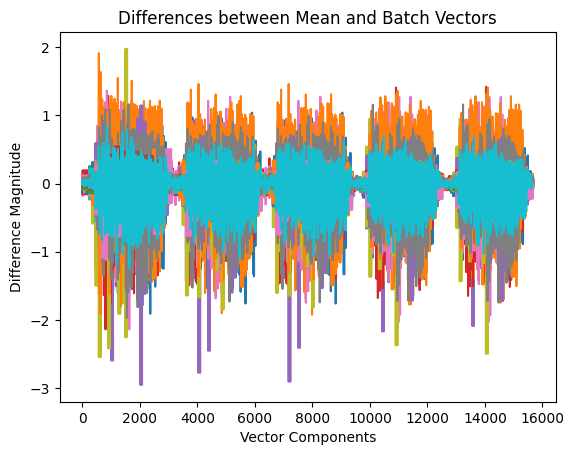

torch.Size([5, 3136])


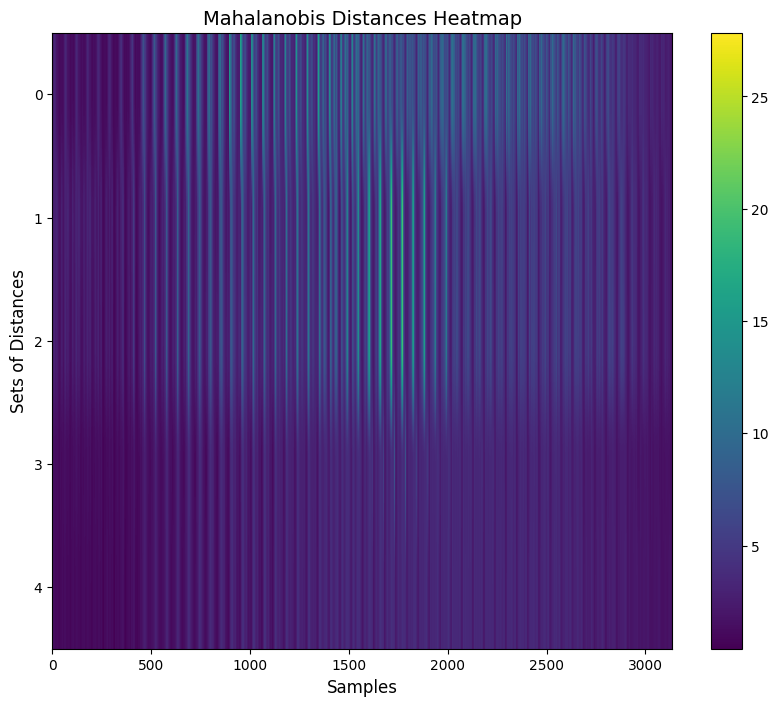

In [14]:
from anodet.utils import mahalanobis

embedding_vectors = padim.embeddings_extractor(
            batch,
            channel_indices=padim.channel_indices,
            layer_hook=padim.layer_hook,
            layer_indices=padim.layer_indices,
        )

distances = mahalanobis(padim.mean, padim.cov_inv, embedding_vectors)

print(distances.shape)

distances_np = distances.detach().numpy()

# Create a heatmap plot
plt.figure(figsize=(10, 8))
plt.imshow(distances_np, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Sets of Distances', fontsize=12)
plt.title('Mahalanobis Distances Heatmap', fontsize=14)
plt.show()

#### Interpret the prediction

In [15]:
THRESH = 13
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([20.1758, 19.7339, 19.5899,  7.5944,  4.2566])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

In [16]:
test_images = np.array(images).copy()

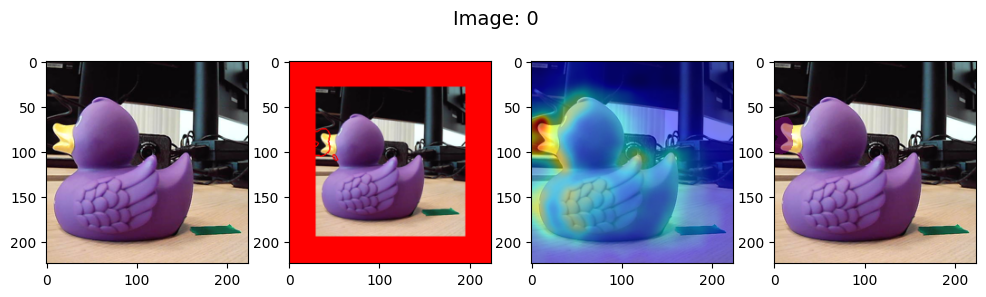

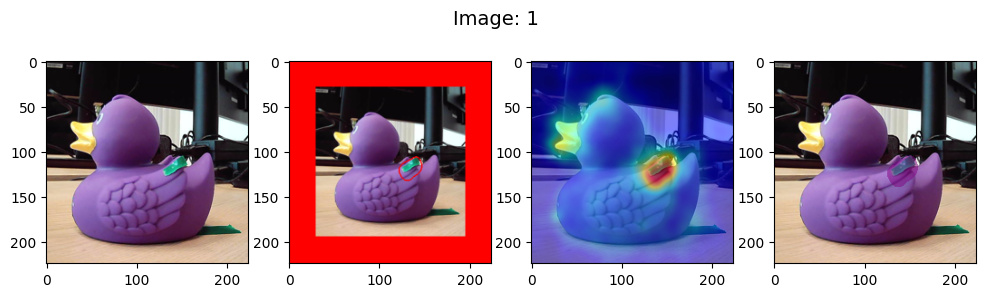

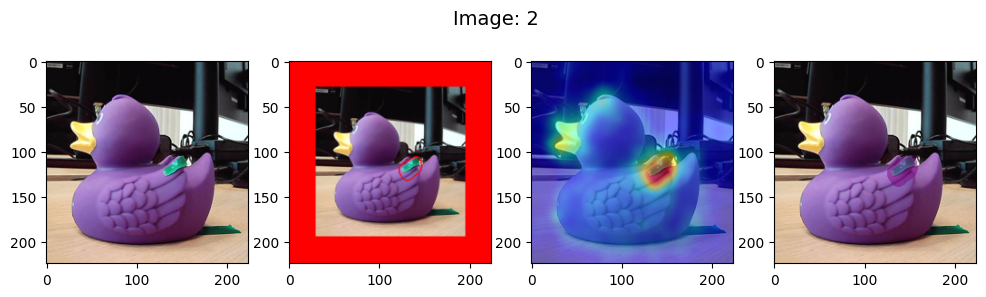

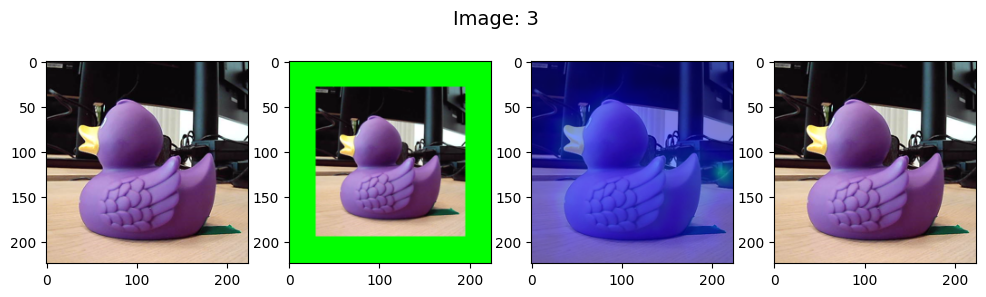

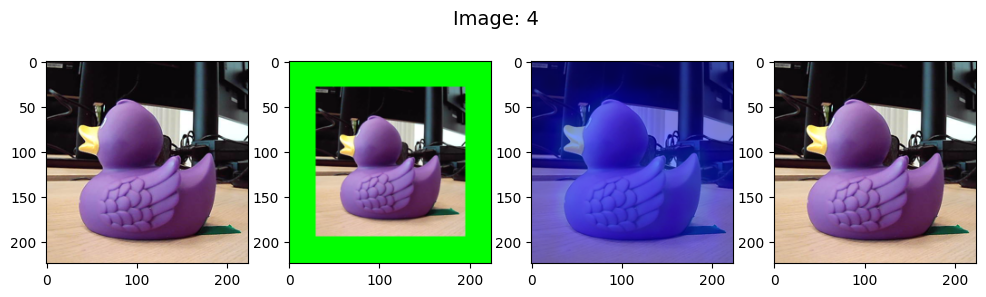

In [17]:
boundary_images = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
highlighted_images = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle('Image: ' + str(idx), y=0.75, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(boundary_images[idx])
    axs[2].imshow(heatmap_images[idx])
    axs[3].imshow(highlighted_images[idx])
    plt.show()

#### For one merged image

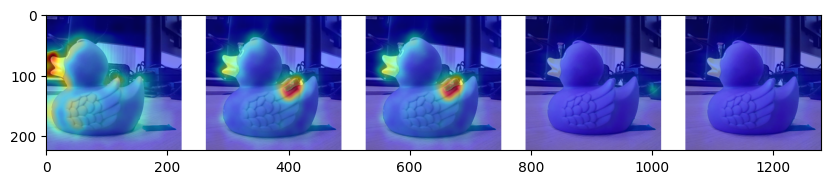

In [18]:
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
tot_img = anodet.visualization.merge_images(heatmap_images, margin=40)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.imshow(tot_img)
plt.show()

In [19]:
print(padim)

Padim(backbone=resnet18, device=cpu, mean=tensor([[2.8942e-01, 1.7433e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.1433e+00],
        [2.8942e-01, 4.4421e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.0942e+00],
        [2.8942e-01, 1.1617e-01, 5.4565e-01,  ..., 3.8126e-01, 0.0000e+00,
         1.2511e+00],
        ...,
        [1.3644e-01, 1.2187e-02, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         0.0000e+00],
        [1.3644e-01, 0.0000e+00, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         2.7906e-04],
        [1.3644e-01, 0.0000e+00, 6.7693e-02,  ..., 3.5398e-03, 0.0000e+00,
         0.0000e+00]]), cov_inv=tensor([[[ 9.8882e+01,  1.5433e-01,  5.0537e-01,  ..., -4.6098e-01,
           0.0000e+00, -8.6831e-02],
         [ 1.5433e-01,  9.8667e+01,  2.9961e-01,  ..., -2.4155e-01,
           0.0000e+00, -1.4212e-01],
         [ 5.0537e-01,  2.9961e-01,  9.6196e+01,  ...,  8.3368e-01,
           0.0000e+00, -1.2028e-02],
         ...,
         [-4.6098e-01, -

---
#### Model Evaluation
Ground truth data is available for the MVTec dataset, but has to be created for any other dataset.

In [22]:
#TODO (?): This need annotated data (ground truth image pixel masks).
if object_name in anodet.MVTecDataset.CLASS_NAMES:
    test_dataset = anodet.MVTecDataset(DATASET_PATH, object_name, is_train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    res = padim.evaluate(test_dataloader)
    images, image_classifications_target, masks_target, image_scores, score_maps = res

    anodet.visualize_eval_data(image_classifications_target, masks_target, image_scores, score_maps)